In [1]:
import os,sys
#Change and check directory
os.chdir('C:\WGU\D208\PA')
os.getcwd()

'C:\\WGU\\D208\\PA'

In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import qqplot
#Regression Modeling
import statsmodels.api as sm
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#load the data frame
df = pd.read_csv('churn_clean.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income                10

In [3]:
#Data Cleaning
#Detect and treat NULLS - we can see from the describe call that there is only one column with missing values
#InternetService: This column actually doesn't have any null values it just got read in as NULL rather than None indicating the customer doesn't have this service
df['InternetService'].fillna('None',inplace=True)

In [4]:
#Drop columns we won't be using
df = df.drop(columns=['Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'TimeZone', 'Area', 'Job', 'Children', 'Age', 'Income', 'Marital', 'Gender', 'Churn', 'Techie', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'])

In [5]:
#Summary Statistics and Reviewing for Outliers
df.describe()

,Population,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9756.562400,10.001848,12.016000,0.994200,0.398000,34.526188,172.624816,3392.341550
std,14432.698671,2.976019,3.025898,0.988466,0.635953,26.443063,42.943094,2185.294852
min,0.000000,0.099747,1.000000,0.000000,0.000000,1.000259,79.978860,155.506715
25%,738.000000,8.018214,10.000000,0.000000,0.000000,7.917694,139.979239,1236.470827
50%,2910.500000,10.018560,12.000000,1.000000,0.000000,35.430507,167.484700,3279.536903
75%,13168.000000,11.969485,14.000000,2.000000,1.000000,61.479795,200.734725,5586.141370
max,111850.000000,21.207230,23.000000,7.000000,6.000000,71.999280,290.160419,7158.981530


In [6]:
categorical_columns = ['Port_modem', 'Tablet', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Contract', 'InternetService', 'PaymentMethod']
for x in categorical_columns:
    print(df[x].describe())

count     10000
unique        2
top          No
freq       5166
Name: Port_modem, dtype: object
count     10000
unique        2
top          No
freq       7009
Name: Tablet, dtype: object
count     10000
unique        2
top         Yes
freq       9067
Name: Phone, dtype: object
count     10000
unique        2
top          No
freq       5392
Name: Multiple, dtype: object
count     10000
unique        2
top          No
freq       6424
Name: OnlineSecurity, dtype: object
count     10000
unique        2
top          No
freq       5494
Name: OnlineBackup, dtype: object
count     10000
unique        2
top          No
freq       5614
Name: DeviceProtection, dtype: object
count     10000
unique        2
top          No
freq       6250
Name: TechSupport, dtype: object
count     10000
unique        2
top          No
freq       5071
Name: StreamingTV, dtype: object
count     10000
unique        2
top          No
freq       5110
Name: StreamingMovies, dtype: object
count     10000
unique        2


In [7]:
#One hot encoding 
continuous_columns = ['Population', 'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype = int)
#Rename the columns for clarity and to remove spaces
df = df.rename(columns = {'Contract_One year':'Contract_One_Year', 'Contract_Two Year':'Contract_Two_Year','InternetService_Fiber Optic':'InternetService_Fiber_Optic', 'InternetService_Fiber Optic':'InternetService_Fiber_Optic', 'PaymentMethod_Credit Card (automatic)':'PaymentMethod_CC', 'PaymentMethod_Electronic Check':'PaymentMethod_ECheck', 'PaymentMethod_Mailed Check':'PaymentMethod_MCheck'})
categorical_columns = ['Port_modem_Yes', 'Tablet_Yes', 'Phone_Yes', 'Multiple_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes', 'Contract_One_Year', 'Contract_Two_Year', 'InternetService_Fiber_Optic','InternetService_None', 'PaymentMethod_CC', 'PaymentMethod_ECheck', 'PaymentMethod_MCheck']
#Store all the columns for easy access later
columns = categorical_columns + continuous_columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Population                   10000 non-null  int64  
 1   Outage_sec_perweek           10000 non-null  float64
 2   Email                        10000 non-null  int64  
 3   Contacts                     10000 non-null  int64  
 4   Yearly_equip_failure         10000 non-null  int64  
 5   Tenure                       10000 non-null  float64
 6   MonthlyCharge                10000 non-null  float64
 7   Bandwidth_GB_Year            10000 non-null  float64
 8   Port_modem_Yes               10000 non-null  int32  
 9   Tablet_Yes                   10000 non-null  int32  
 10  Phone_Yes                    10000 non-null  int32  
 11  Multiple_Yes                 10000 non-null  int32  
 12  OnlineSecurity_Yes           10000 non-null  int32  
 13  OnlineBackup_Yes     

In [8]:
df.head()

,Population,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,Port_modem_Yes,Tablet_Yes,...,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Contract_One_Year,Contract_Two_Year,InternetService_Fiber_Optic,InternetService_None,PaymentMethod_CC,PaymentMethod_ECheck,PaymentMethod_MCheck
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,38,7.978323,10,0,1,6.795513,172.455519,904.536110,1,1,...,0,1,1,1,0,1,0,1,0,0
2,10446,11.699080,12,0,1,1.156681,242.632554,800.982766,0,1,...,1,1,1,0,0,1,0,0,0,0
3,3735,10.752800,9,0,1,15.754144,159.947583,2054.706961,1,0,...,0,1,1,0,1,0,0,1,0,0
4,13863,14.913540,15,2,0,17.087227,119.956840,2164.579412,0,0,...,1,0,1,0,1,0,0,0,0,1
5,11352,8.147417,16,2,1,1.670972,149.948316,271.493436,1,0,...,1,0,0,0,0,1,0,0,0,1


array([[<Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'Outage_sec_perweek'}>,
        <Axes: title={'center': 'Email'}>,
        <Axes: title={'center': 'Contacts'}>,
        <Axes: title={'center': 'Yearly_equip_failure'}>],
       [<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'MonthlyCharge'}>,
        <Axes: title={'center': 'Bandwidth_GB_Year'}>,
        <Axes: title={'center': 'Port_modem_Yes'}>,
        <Axes: title={'center': 'Tablet_Yes'}>],
       [<Axes: title={'center': 'Phone_Yes'}>,
        <Axes: title={'center': 'Multiple_Yes'}>,
        <Axes: title={'center': 'OnlineSecurity_Yes'}>,
        <Axes: title={'center': 'OnlineBackup_Yes'}>,
        <Axes: title={'center': 'DeviceProtection_Yes'}>],
       [<Axes: title={'center': 'TechSupport_Yes'}>,
        <Axes: title={'center': 'StreamingTV_Yes'}>,
        <Axes: title={'center': 'StreamingMovies_Yes'}>,
        <Axes: title={'center': 'PaperlessBilling_Yes'}>,
        <A

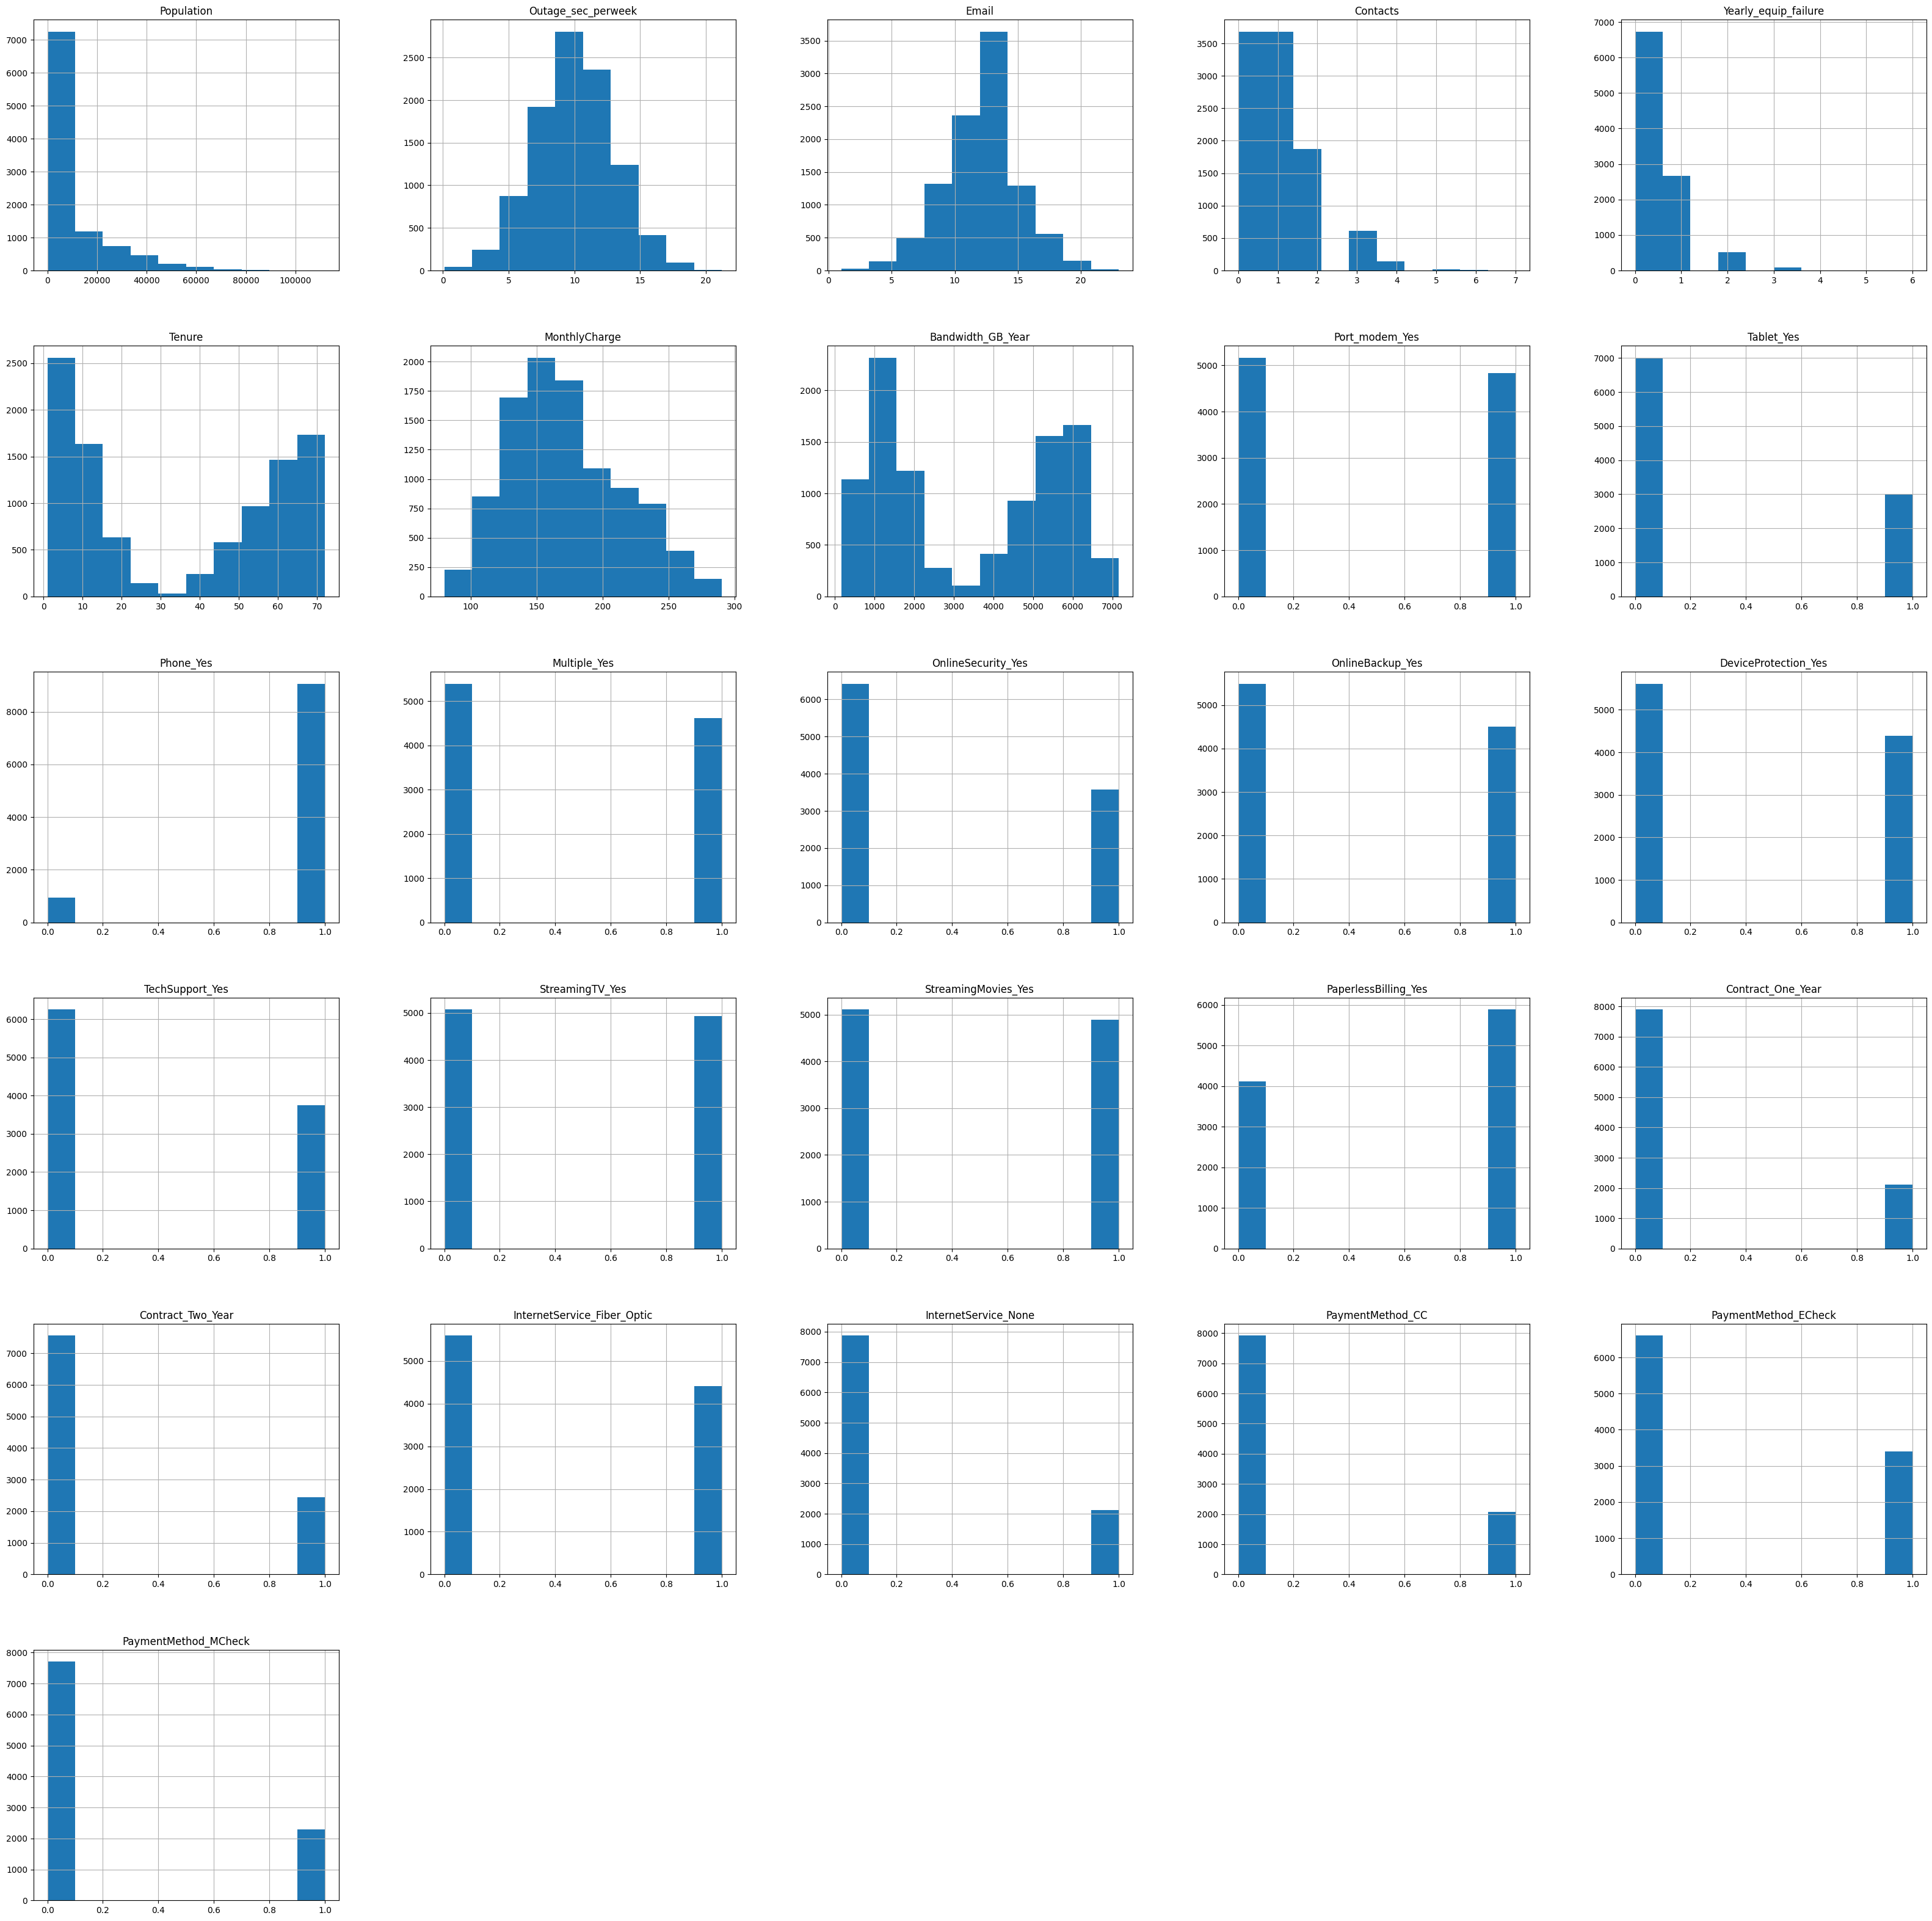

In [9]:
#Visualizations
#Univariate
df.hist(figsize =(40,40))

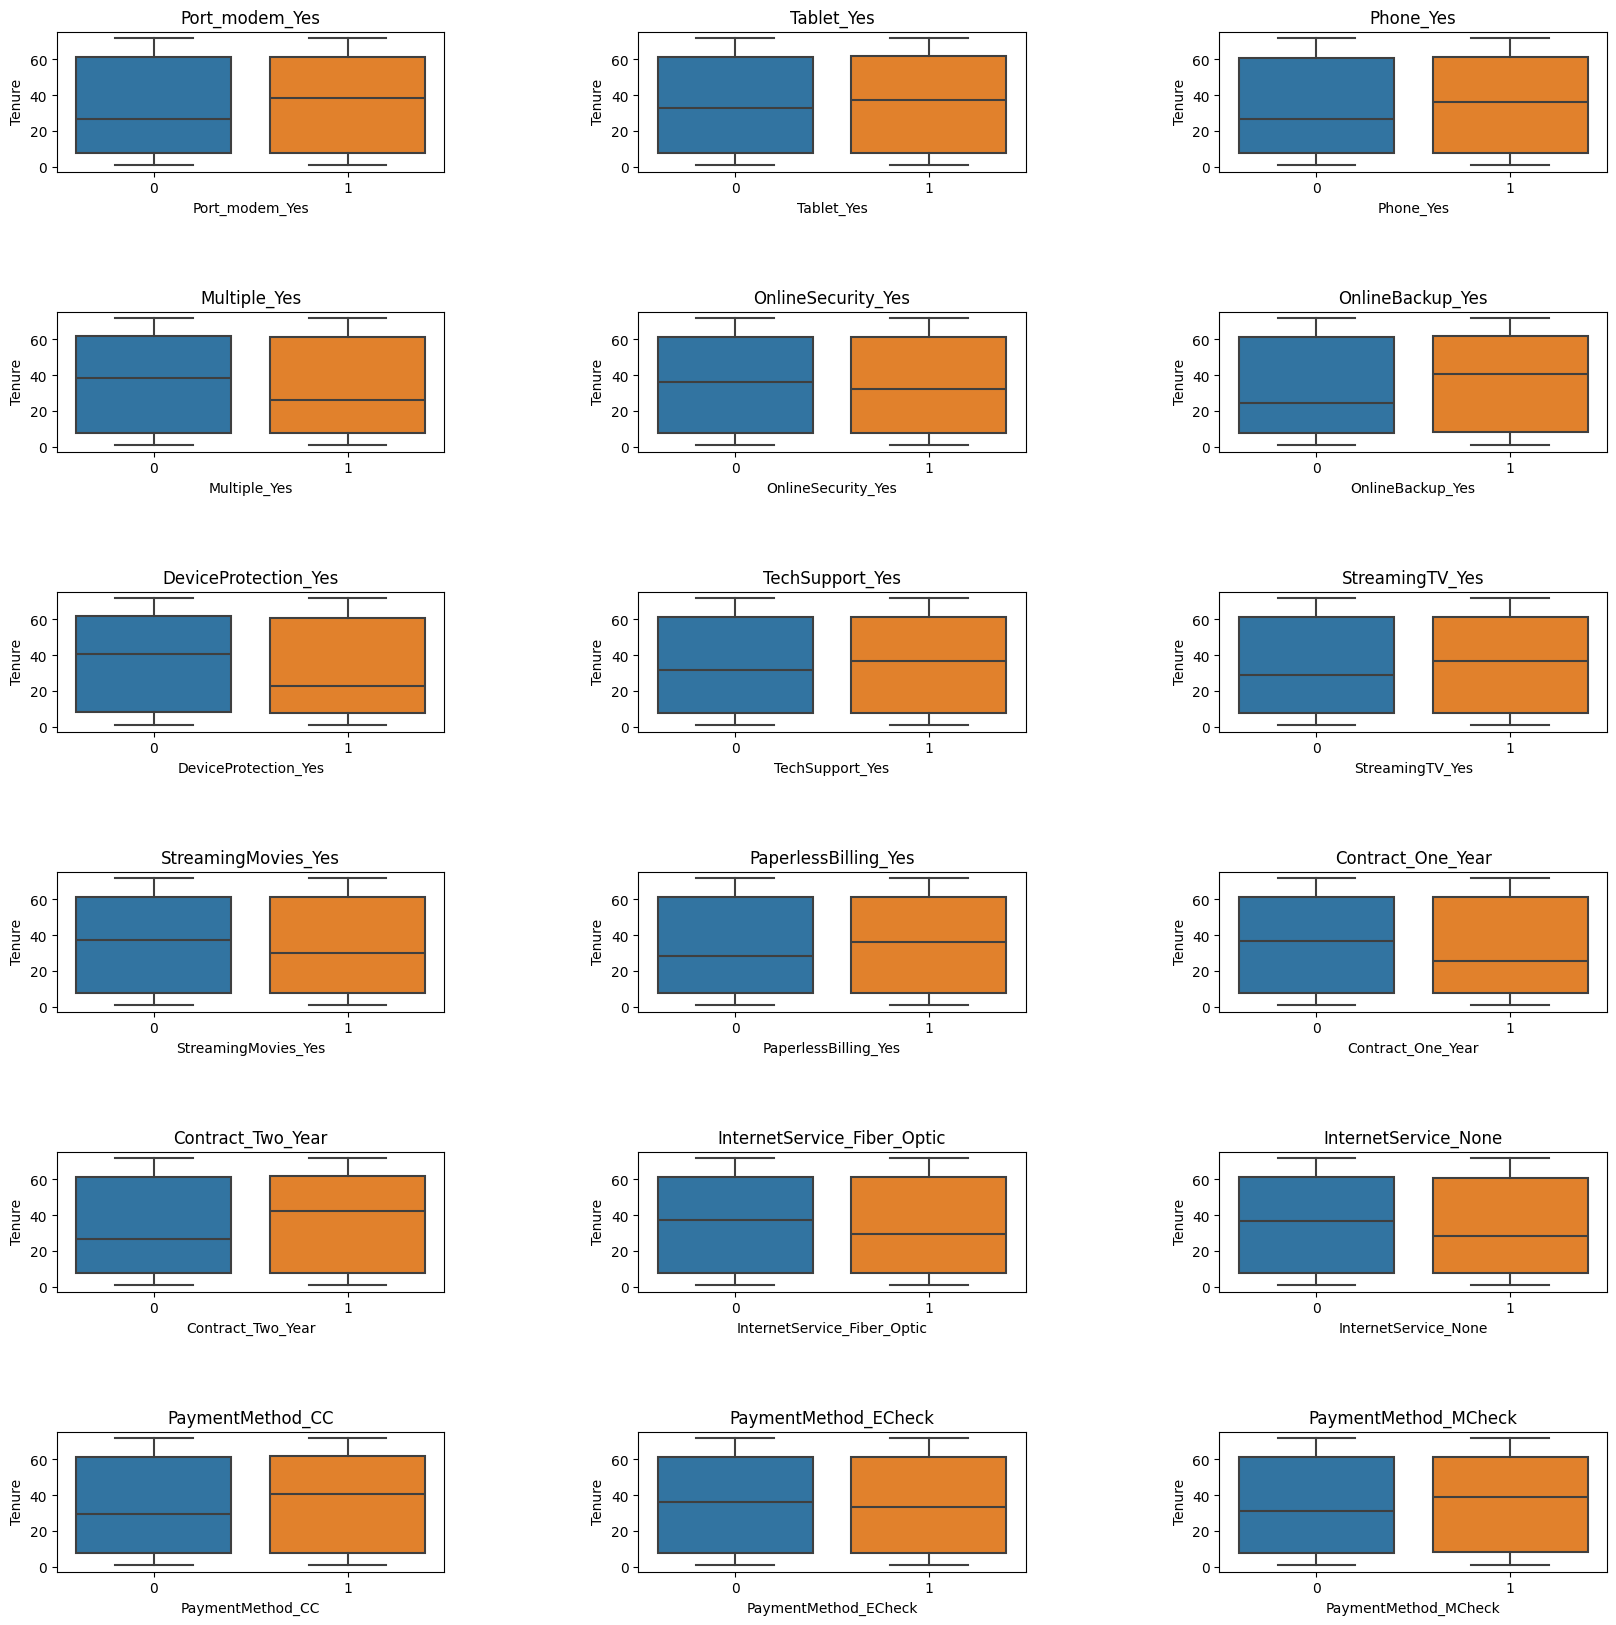

In [10]:
#Boxplots
fig, axis = plt.subplots(6, 3, figsize=(20, 20))
i = 0
len_axis = len(axis)
for row in axis:
    for plot in row:
        plt.subplots_adjust(wspace=0.5, hspace=1)
        sns.boxplot(data = df, ax=plot, x=categorical_columns[i], y=df["Tenure"]).set(title=categorical_columns[i])
        i = i+1
plt.show()

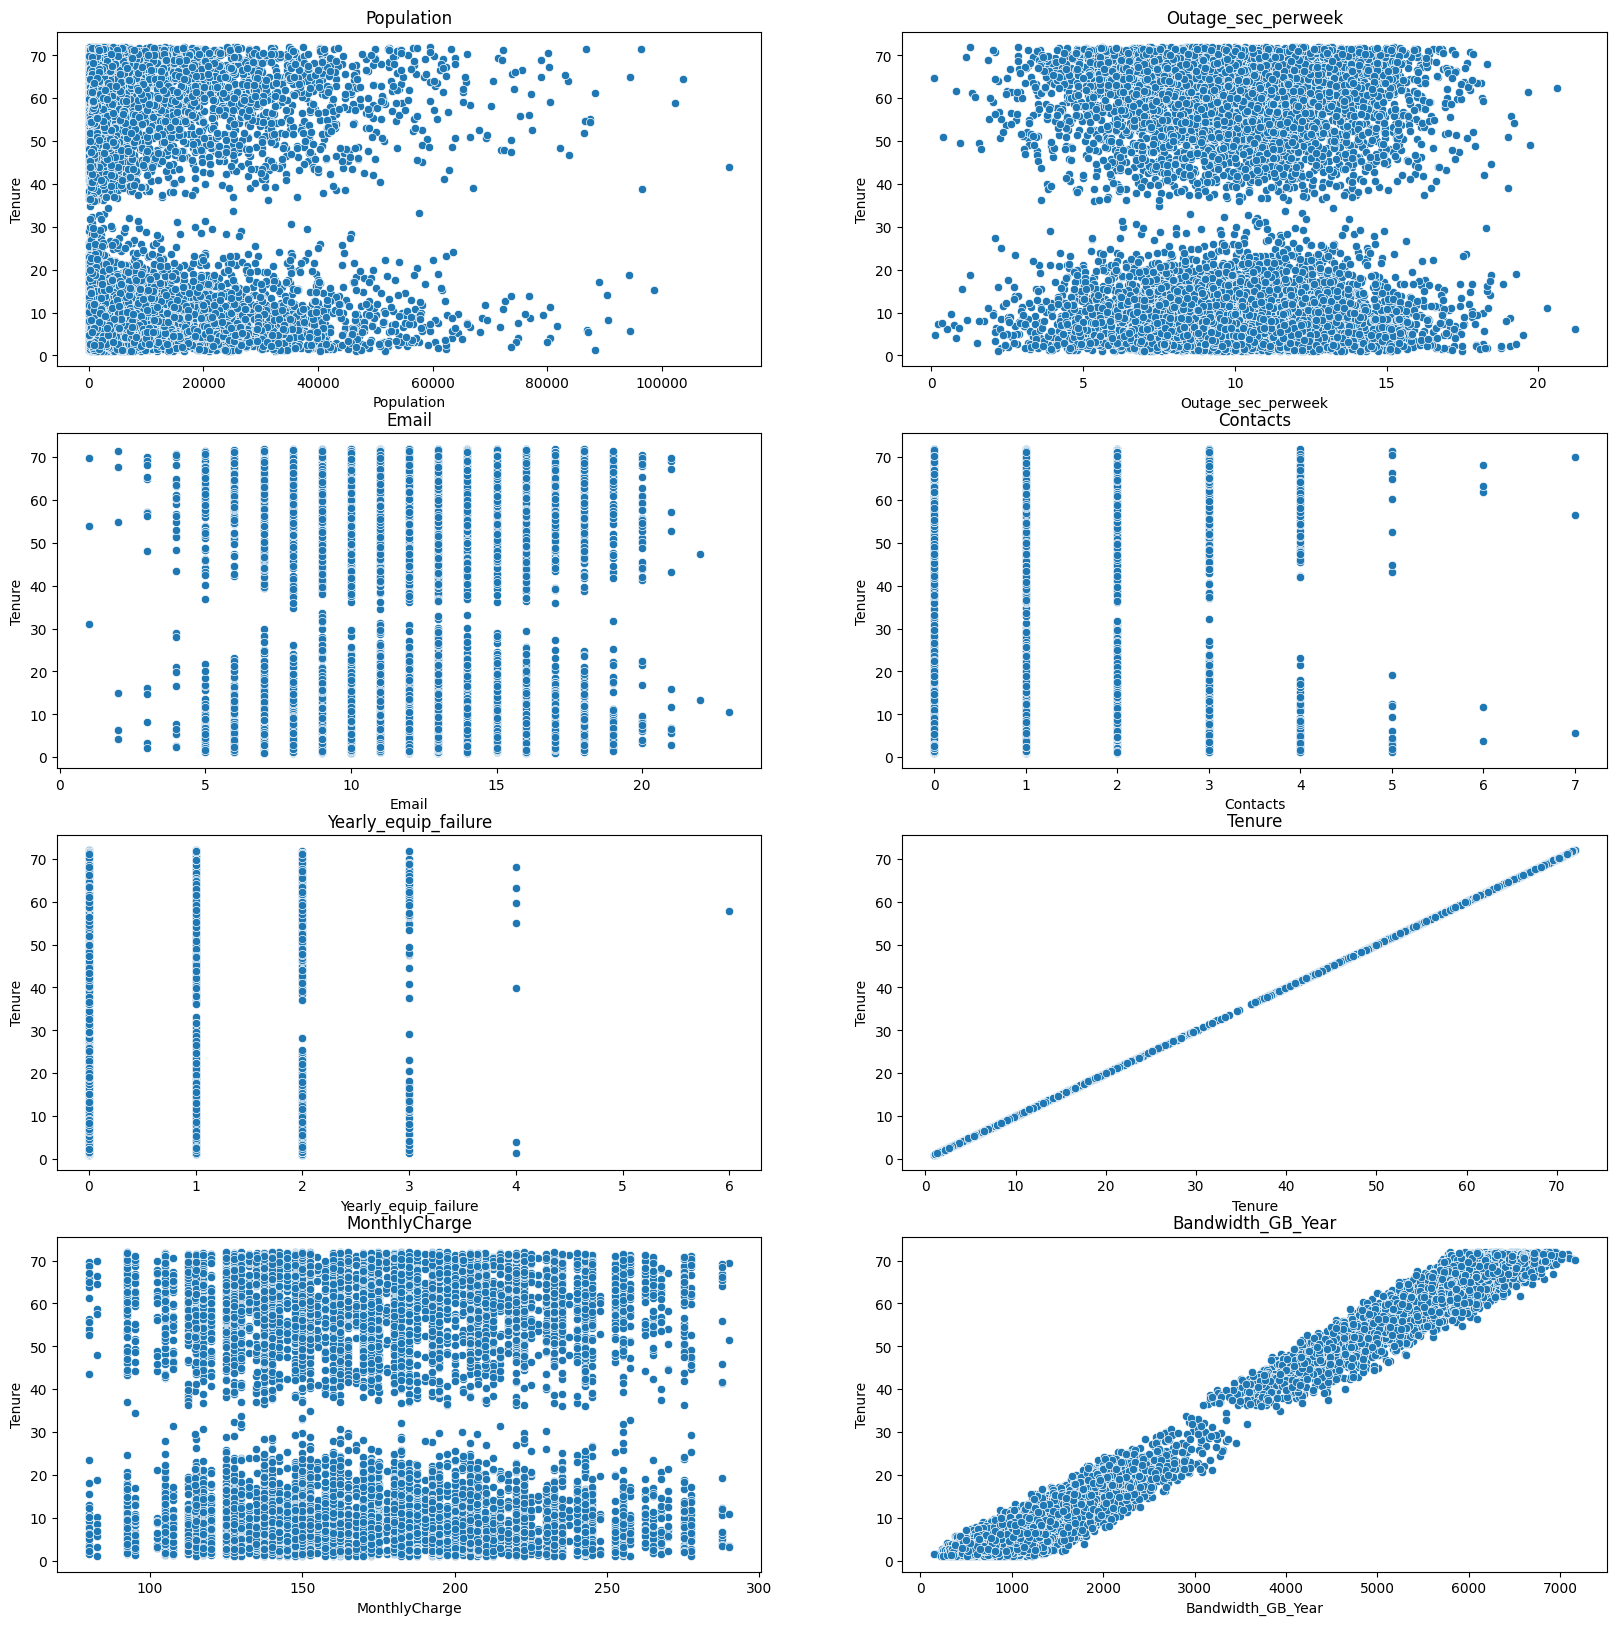

In [11]:
#Bivariate
#Scatterplots 
fig, axis = plt.subplots(4, 2, figsize=(20, 20))
i = 0
len_axis = len(axis)
for row in axis:
    for plot in row:
        sns.scatterplot(data=df, x=continuous_columns[i], y=df["Tenure"], ax=plot).set(title=continuous_columns[i])
        i = i+1
plt.show()

In [12]:
#Export the prepared data set
df.to_csv('PREPARED_churn_clean_data.csv')

In [13]:
#Initial Model
columns.remove("Tenure")
X = df[columns]
y = df['Tenure']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Tenure   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.805e+05
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:42:36   Log-Likelihood:                -16354.
No. Observations:               10000   AIC:                         3.276e+04
Df Residuals:                    9974   BIC:                         3.295e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

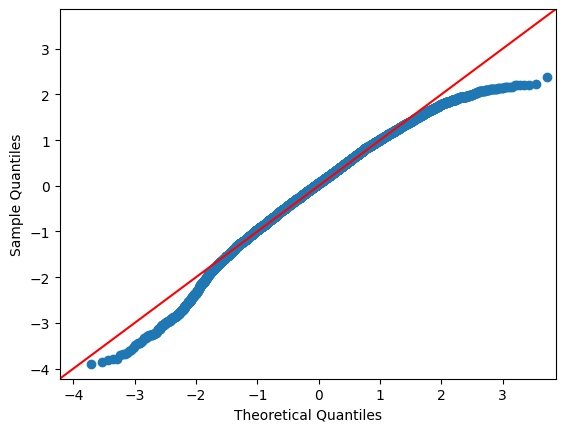

In [14]:
#QQPlot Initial Model
qqplot(data = model.resid, fit = True, line = "45");

In [15]:
#Reduced Model
#Check for multicolinearity
#calculate VIF for each explanatory variable
mc_check = pd.DataFrame()
mc_check['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
mc_check['column'] = X.columns

#view VIF for each explanatory variable 
mc_check

,VIF,column
0,148.883518,const
1,1.000988,Port_modem_Yes
2,1.003683,Tablet_Yes
3,1.002909,Phone_Yes
4,4.421222,Multiple_Yes
5,1.024254,OnlineSecurity_Yes
6,2.633890,OnlineBackup_Yes
7,1.502046,DeviceProtection_Yes
8,1.481349,TechSupport_Yes
9,6.764570,StreamingTV_Yes


In [16]:
#Create a new column to keep the reduced columns
reduced_columns = columns
#Remove columns with a severe correlation (VIF > 5)
index = 0
for VIF in mc_check["VIF"]:
    if VIF > 5 and mc_check["column"][index] != "const":
        reduced_columns.remove(mc_check["column"][index])
        print("Column removed: " + mc_check["column"][index])
    index+=1

Column removed: StreamingTV_Yes
Column removed: StreamingMovies_Yes
Column removed: MonthlyCharge


In [17]:
#Model after removing high VIF
X = df[reduced_columns]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Tenure   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 6.133e+04
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:42:37   Log-Likelihood:                -22367.
No. Observations:               10000   AIC:                         4.478e+04
Df Residuals:                    9977   BIC:                         4.495e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [18]:
#Backwards Stepwise Regression
#Keep reducing until all the p-values are below .05
while model.pvalues.max() > .05:
    max_P = model.pvalues.max()
    for column in X:
        if(model.pvalues.loc[column] == max_P):
            reduced_columns.remove(column)
            print("Column removed: " + column)
            break
    X = df[reduced_columns]
    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()

Column removed: Yearly_equip_failure
Column removed: Port_modem_Yes
Column removed: TechSupport_Yes
Column removed: Contacts
Column removed: PaperlessBilling_Yes
Column removed: PaymentMethod_ECheck
Column removed: PaymentMethod_MCheck
Column removed: Email
Column removed: PaymentMethod_CC
Column removed: Contract_Two_Year
Column removed: Population
Column removed: Phone_Yes
Column removed: Contract_One_Year
Column removed: Outage_sec_perweek


In [19]:
# Final Reduced Model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Tenure   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.686e+05
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:42:38   Log-Likelihood:                -22375.
No. Observations:               10000   AIC:                         4.477e+04
Df Residuals:                    9991   BIC:                         4.483e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

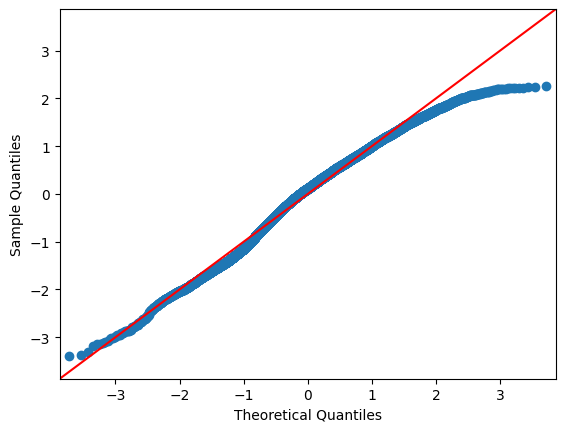

In [20]:
#QQPlot Reduced Model
qqplot(data = model.resid, fit = True, line = "45");

In [21]:
model.resid.std(ddof=X.shape[1])

2.26835397251624